In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v2 import keras
from tensorflow.compat.v2.keras import layers
import tensorflow_datasets as tfds

In [3]:
%tensorflow_version 2.x
print(tf.__version__)
!nvidia-smi
tf.enable_v2_behavior()

2.2.0-rc2
Tue Apr 14 03:18:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory 

In [4]:
train_data, info = tfds.load(name="cifar10", split='train[10:]',  with_info = True, data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
valid_data = tfds.load(name="cifar10", split='train[:10]',  data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
test_data = tfds.load(name="cifar10", split='test', data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/cifar10/3.0.0.incomplete9D34B5/cifar10-train.tfrecord


Shuffling and writing examples to /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/cifar10/3.0.0.incomplete9D34B5/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [7]:
train_data.output_shapes

{'image': TensorShape([32, 32, 3]), 'label': TensorShape([])}

In [8]:
train_data

<DatasetV1Adapter shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

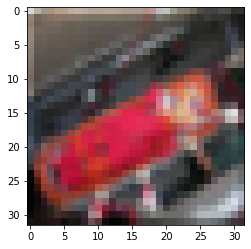

In [9]:
for example in train_data.take(1):  # Only take a single example
  image_test, label = example["image"], example["label"]
  plt.figure()
  plt.imshow(image_test.numpy())

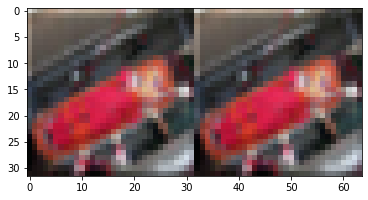

In [10]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

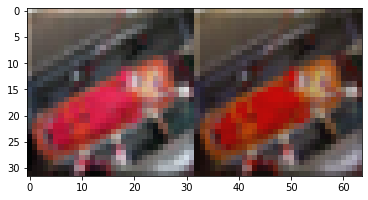

In [11]:
def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

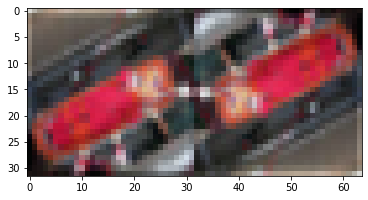

In [12]:
def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

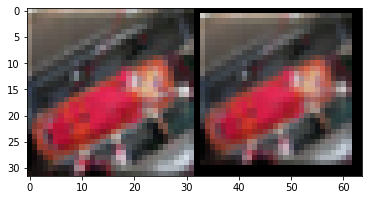

In [13]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

image_2 = zoom(image_test)
# 因為處理後影像會變成float型態，所以需轉換回來不然顯示時會出現問題
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))  # 將原始圖和處理後水平合併
plt.imshow(image)

In [0]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['label'], 10)
    return x, y
  

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
# 載入前面的資料預處理function，cpu數量為自動調整模式
train_data = train_data.shuffle(info.splits['train'].num_examples)  # 打散資料集
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

NameError: ignored

In [0]:
train_data

In [0]:
# 由於前面已經將train_data batch size設定為64，所以取一次資料就有64筆
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

In [0]:
model_dir = '/content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models'  # 設定儲存權重目錄
if os.path.exists(model_dir) == False:
    os.makedirs(model_dir)  # 創建儲存權重目錄

In [0]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # 顯示網路架構
# 儲存訓練記錄檔
# 將訓練記錄，存成TensorBoard的紀錄檔
log_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [0]:
history_3 = model_3.fit(train_data,
                        epochs=10, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp],
                        verbose=2)

In [0]:
loss, acc = model_3.evaluate(test_data)
print('\nModel-3 Accuracy: {}%'.format(acc))